In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR


import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv,GraphConv, ChebConv
from torch_geometric.data import Data

import pyproj

PROJ = pyproj.Proj(proj='stere',  a=6378273, b=6378273, lon_0=-45, lat_0=90, lat_ts=90)

##Adding src path to get our code
import sys
sys.path.append('../src')
from ice_graph.ice_graph import Nextsim_data, Ice_graph
from utils.graph_utils import standardize_graph_features
from models.training_utils import process_dataloader

## Sea Ice ML - Training and data handling example

Here it is presented how to create custom graphs centered on neXTSIM elements, convert them into pytorch geometric data classes and train a simple GNN to predict trajectories.

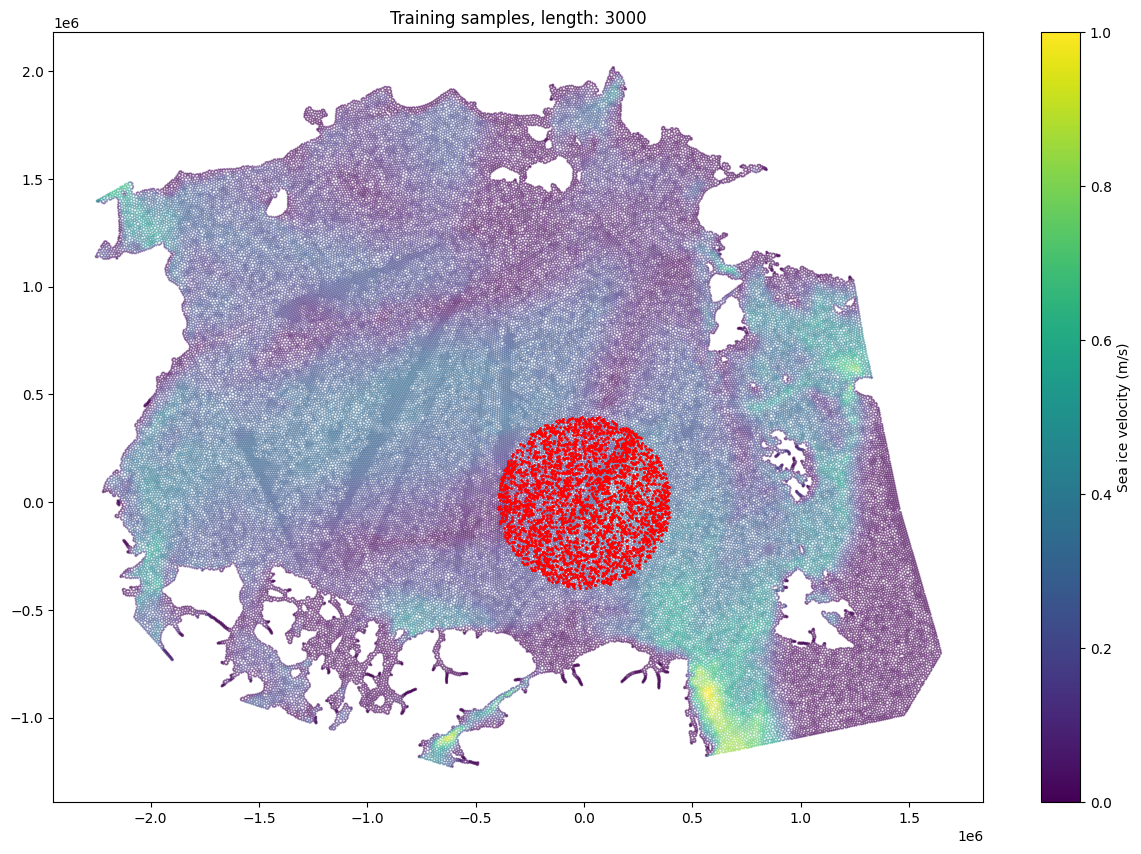

In [2]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

#Here we can generate samples from an hour snapshot to create a training dataset
#We can either select randomly or within a radious from a given element.
#seed for reproducibility
np.random.seed(42)


n_generations = 3000

radius = 400000 #meters
n_neighbours = 4
iterations = 5
time_index = 6 #index of element graph to fetch samples from
val_time_index = time_index+iterations

samples_train = nextsim.get_samples_area((0,0),radius,time_index=time_index,n_samples=n_generations)
samples_val = nextsim.get_samples_area((0,0),radius,time_index=val_time_index,n_samples=int(n_generations/4)) #just 1/4 of items for validation

selected_graph = nextsim.get_item(time_index) 

#plot area defined by radius
plt.figure(figsize=(15,10))
vel_norm = np.sqrt(selected_graph['M_VT_x']**2 + selected_graph['M_VT_y']**2)
plt.scatter(selected_graph['x'],selected_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7,alpha=.4)
plt.title("Training samples, length: "+str(len(samples_train)))
plt.scatter(selected_graph['x'][samples_train],selected_graph['y'][samples_train], color='red',s= 7 ,marker='.',linewidths=.7)
plt.colorbar(label='Sea ice velocity (m/s)')


element_g = nextsim.get_element_graph(samples_train[400],time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,predict_element=True)
vertex_g = nextsim.get_vertex_graph(samples_train[400],time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,predict_element=False)


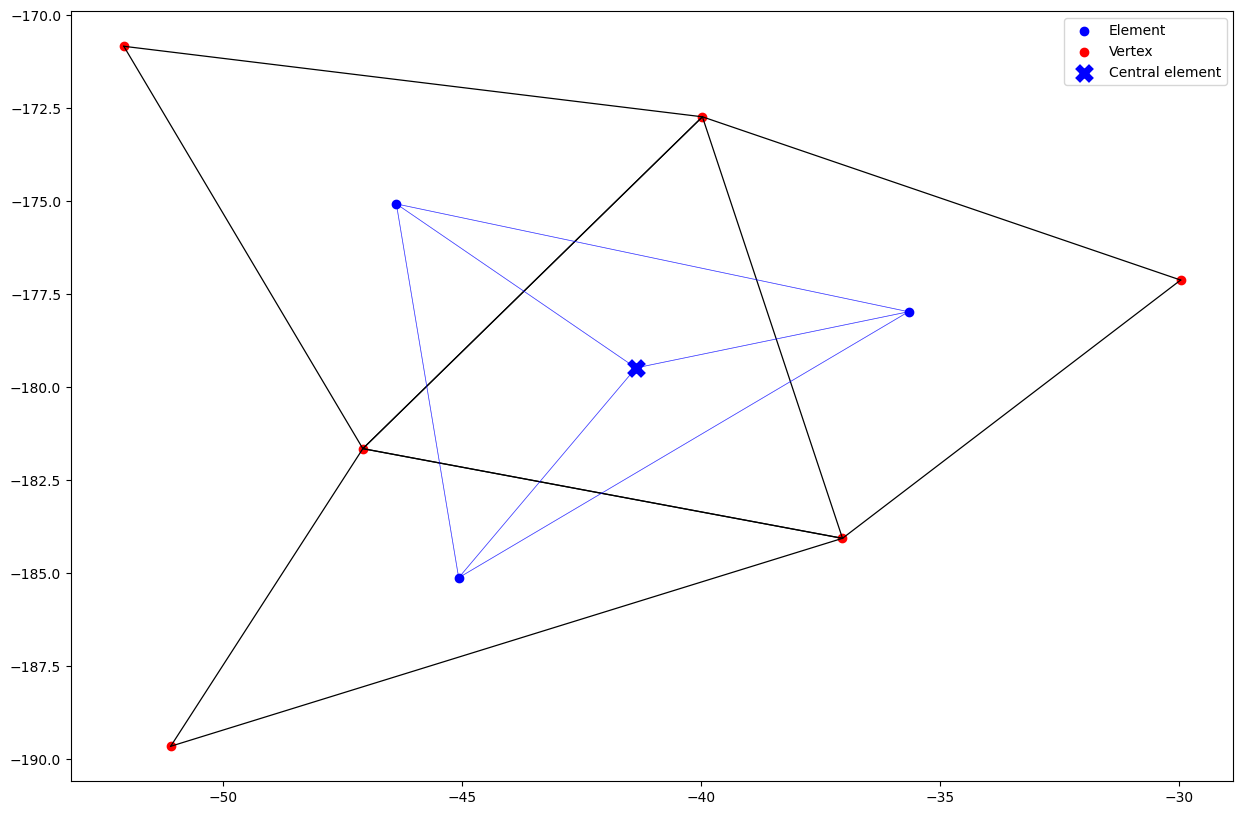

In [3]:
plt.figure(figsize=(15,10))
central_pos = selected_graph['x'][samples_train[400]]/1000,selected_graph['y'][samples_train[400]]/1000


for edge in vertex_g.edge_index.t():
    positions = np.array([vertex_g.pos.t()[edge[0]],vertex_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='black',linewidth=.9)

for edge in element_g.edge_index.t():
    positions = np.array([element_g.pos.t()[edge[0]],element_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='blue',linewidth=.5,alpha=.5)

plt.scatter(element_g.pos[0],element_g.pos[1],color='blue',label='Element')
plt.scatter(vertex_g.pos[0],vertex_g.pos[1],color='red',label='Vertex')

plt.scatter(central_pos[0],central_pos[1],marker='x', s=100, linewidth=5, c='blue', label='Central element')

plt.legend()

In [4]:
train_graph_list = []
fet = ['Damage', 'Concentration', 'Thickness', 'Sigma_0', 'Sigma_1', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
for sample in tqdm(samples_train,"Generating training graphs"):
    graph = nextsim.get_element_graph(sample,time_index=time_index,n_neighbours=n_neighbours,target_iter=iterations,features=fet,predict_element=True)
    if graph is not None:
        train_graph_list.append(graph)
        
val_graph_list = []
for sample in tqdm(samples_val,"Generating validation graphs"):
    graph = nextsim.get_element_graph(sample,time_index=val_time_index,n_neighbours=n_neighbours,target_iter=iterations,features=fet,predict_element=True)
    if graph is not None:
        val_graph_list.append(graph)

Generating validation graphs: 100%|██████████| 750/750 [00:06<00:00, 120.13it/s]


In [7]:
#standardize features
train_graph_list = standardize_graph_features(train_graph_list)
val_graph_list = standardize_graph_features(val_graph_list)

### Code implementation
##### To be cleaned an implemented into project structure

In [8]:
#Dataset: serves to fetch graph data on dataloaders or training loop. Its a standard torch class to manage information, transfrom and iterate over it
class Ice_graph_dataset(Dataset):
    def __init__(self, data_list, transform = None):
        super(Ice_graph_dataset, self).__init__()

        # List of graphs
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        if self.transform is not None:
            data.x = self.transform(data.x.unsqueeze(dim=0).moveaxis(-1,0)).squeeze().moveaxis(0,-1)

        return data
    

class GCNN_node(nn.Module):

    def __init__(self, num_features, hidden_channels, output_size):
        super(GCNN_node, self).__init__()
        # conv layers as a test [WIP]
        self.conv1 = ChebConv(num_features, hidden_channels,K=1)
        self.fc = nn.Linear(hidden_channels, output_size)

    def forward(self, x, edge_index,edge_attr):
        x = self.conv1(x, edge_index,edge_attr)
        x = F.relu(x)

        # Global pooling to aggregate node features (... not sure how elegant)
        x = torch.mean(x, dim=0)

        # Fully connected layer for the final output
        x = self.fc(x)


        return x

In [13]:
# Dataset creation, model definition and training
# Note in here we are only overfitting ot study the fesiability of the approach

#create datasets and loaders
train_dataset = Ice_graph_dataset(train_graph_list, transform=None)
val_dataset = Ice_graph_dataset(val_graph_list, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

example_graph = next(iter(train_dataset)) #just to get the num_features

num_features = example_graph.x.shape[-1]  # Node feature dimension
hidden_channels = 12
num_classes = example_graph.y[0].shape[0] # trajectory lenght *2, since we have x,y. #CAREFULL!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_node(num_features, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
mse = nn.MSELoss()
num_epochs = 50
scheduler = ExponentialLR(optimizer, gamma=0.9)

#trianing loop
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    training_loss = process_dataloader(model, train_dataloader, device, optimizer, scheduler, mse)
    training_losses.append(training_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {training_loss:.4f}")

    val_loss = process_dataloader(model, val_dataloader, device, criterion=mse)
    validation_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {val_loss:.4f}")

    scheduler.step() if scheduler else None



Epoch 1/100, Average Loss: 1452.5170
Epoch 6/100, Average Loss: 6.2367
Epoch 11/100, Average Loss: 2.0587
Epoch 16/100, Average Loss: 0.9453
Epoch 21/100, Average Loss: 0.5602
Epoch 26/100, Average Loss: 0.4015
Epoch 31/100, Average Loss: 0.3314
Epoch 36/100, Average Loss: 0.2967
Epoch 41/100, Average Loss: 0.2779
Epoch 46/100, Average Loss: 0.2667
Epoch 51/100, Average Loss: 0.2602
Epoch 56/100, Average Loss: 0.2562
Epoch 61/100, Average Loss: 0.2539
Epoch 66/100, Average Loss: 0.2524
Epoch 71/100, Average Loss: 0.2515
Epoch 76/100, Average Loss: 0.2510


KeyboardInterrupt: 

(7889, 2)


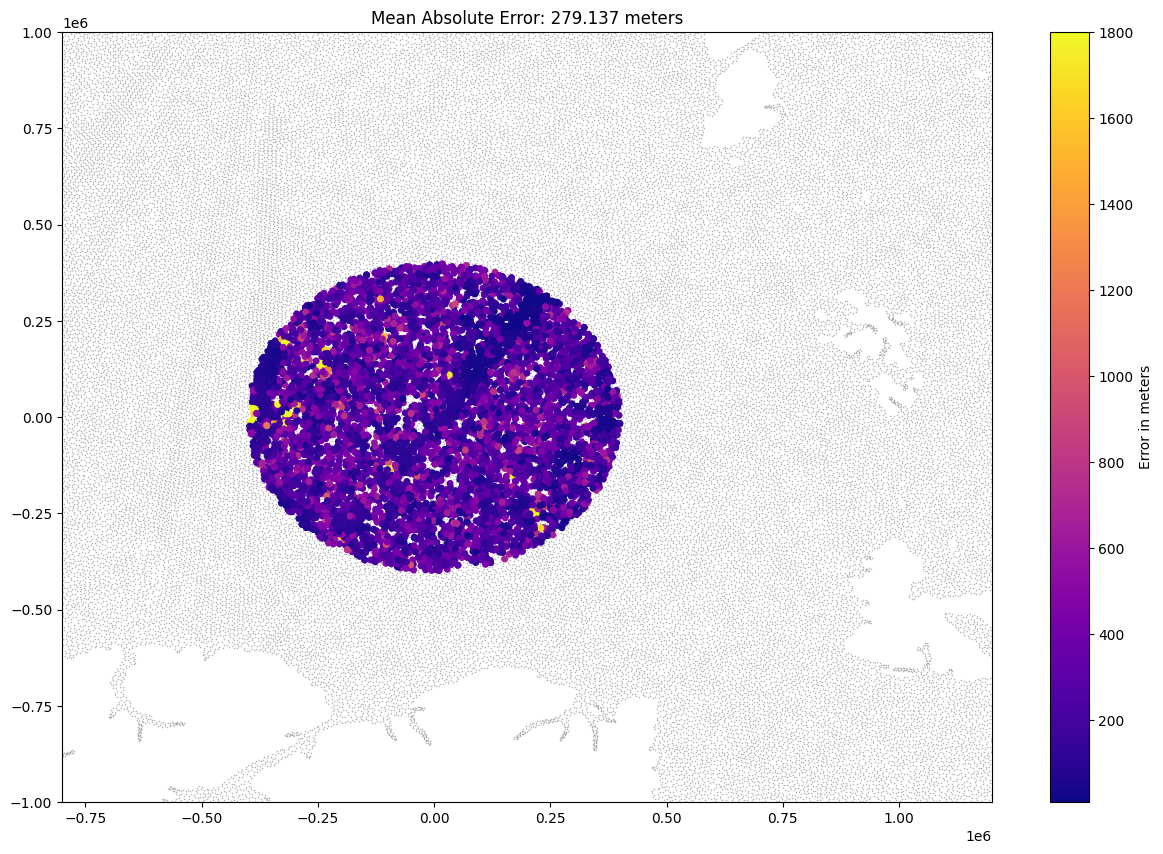

In [15]:
mae =  nn.L1Loss()
lossess = []
all_coords = []
for graph in ice_dataset:
        graph = graph.to(device)
        output = model(graph.x, graph.edge_index, graph.edge_attr)
        loss = mae(output, graph.y[0]).to('cpu').detach().numpy() *1000
        coords = graph.y[-1]
        lossess.append(loss)
        all_coords.append(coords)

avg_loss = np.array(lossess).mean()
all_coords = np.stack(all_coords)*1000

print(all_coords.shape)
plt.figure(figsize=(15,10))
plt.scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
plt.scatter(all_coords[:,0],all_coords[:,1],c=np.clip(lossess,0,1800),s=16, cmap='plasma')
plt.xlim([-0.8e6, 1.2e6])
plt.ylim([-1e6, 1e6])
plt.title("Mean Absolute Error: "+str(avg_loss-1)[:7]+" meters")
plt.colorbar( label="Error in meters")


/tmp/ipykernel_34627/1687646107.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lossess)


Text(0.5, 0, 'MAE (meters)')

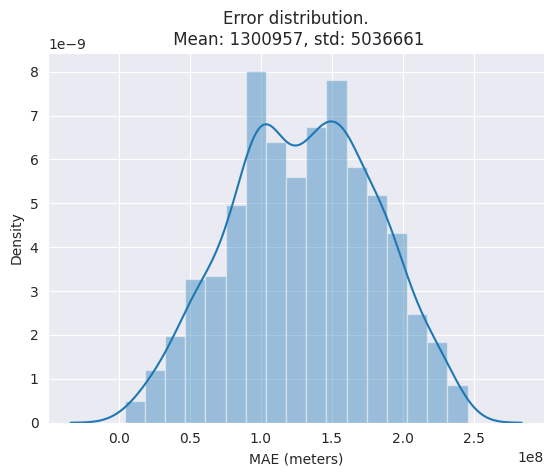

In [16]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(lossess)
plt.title(f"Error distribution.\n Mean: {str(avg_loss-1)[:7]}, std: {str(np.array(lossess).std())[:7]}")
plt.xlabel("MAE (meters)")


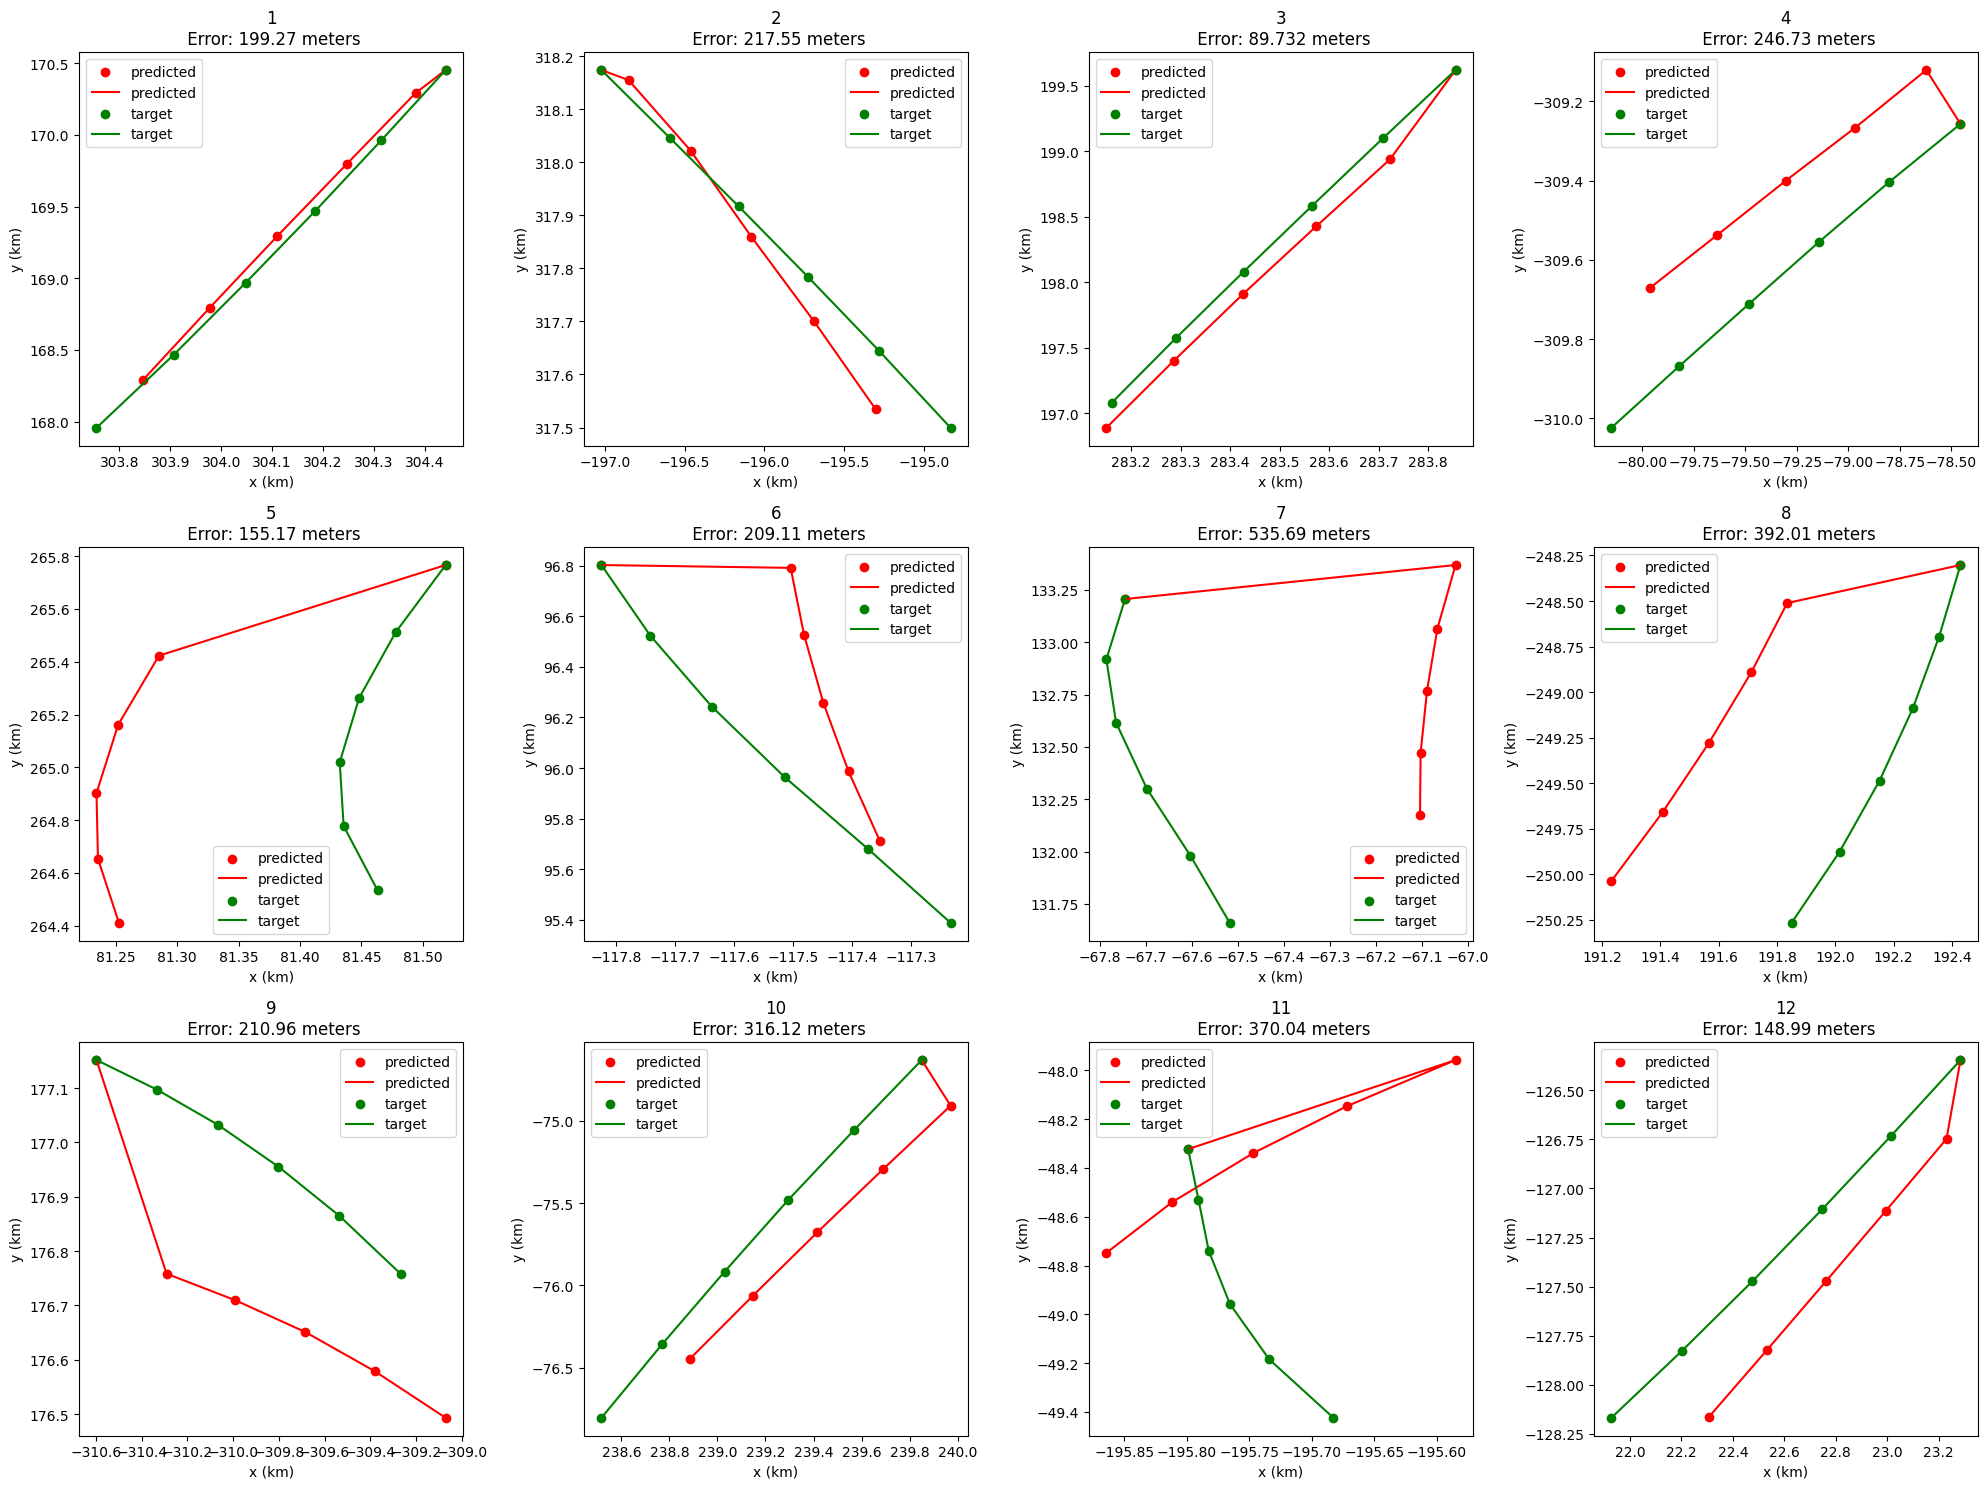

In [17]:
samples = [33, 222, 111,  666,
           333,4,44,555,
           341, 453, 23, 800]

target_iter = iterations
fig,axs = plt.subplots(3,4,figsize=(20,15))

for i,element in enumerate(samples):
    graph = graph_list[element]
    init_coords = graph.y[-1]
    graph = graph.to(device)

    output = model(graph.x, graph.edge_index, graph.edge_attr).cpu().detach().numpy()
    pred_x,pred_y = output[:target_iter],output[target_iter:]
    pred_x,pred_y = np.insert(pred_x,0,init_coords[0]), np.insert(pred_y,0,init_coords[1])

    target = graph.y[0].cpu().detach().numpy()
    target_x,target_y = target[:target_iter],target[target_iter:]
    target_x,target_y = np.insert(target_x,0,init_coords[0]), np.insert(target_y,0,init_coords[1])

    error = mae(torch.tensor(output),torch.tensor(target)).item()*1000
    
    axs.flatten()[i].scatter(pred_x,pred_y, c='red',label="predicted")
    axs.flatten()[i].plot(pred_x,pred_y, c='red',label="predicted")

    axs.flatten()[i].scatter(target_x,target_y, c='green',label="target")
    axs.flatten()[i].plot(target_x,target_y, c='green',label="target")

    #axs.flatten()[i].set_xlim([target_x[0]-10, target_x[0]+10]) # 10km
    #axs.flatten()[i].set_ylim([target_y[0]-10, target_y[0]+10])
    axs.flatten()[i].legend()
    axs.flatten()[i].set_title(f"{i+1}\n Error: "+str(error)[:6]+" meters")
    axs.flatten()[i].set_xlabel("x (km)")
    axs.flatten()[i].set_ylabel("y (km)")
plt.tight_layout()

